In [ ]:
!pip install ftfy

     |████████████████████████████████| 71kB 5.1MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=4e122e4e562a4c51c48ec901e2ae61d2098899ed17addbc749bf8d41b3f1d435
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import re
import nltk
from keras.layers import LSTM,GRU
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.preprocessing.text import Tokenizer
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import LearningRateScheduler
from keras.layers import Bidirectional,GlobalMaxPool1D
import ftfy
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

In [ ]:
DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 4000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2
LEARNING_RATE = 0.001
EPOCHS= 10

In [ ]:
depressive_tweets_df = pd.read_csv('/content/drive/MyDrive/depressive_tweets_processed.csv', sep = '|', header = None, usecols = range(0,9), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis Dataset 2.csv', encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [ ]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [ ]:
depressive_tweets_arr = [x for x in depressive_tweets_df[5]]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

In [ ]:
from wordcloud import WordCloud
depressive_words = ' '.join(list(map(str, depressive_tweets_arr)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)

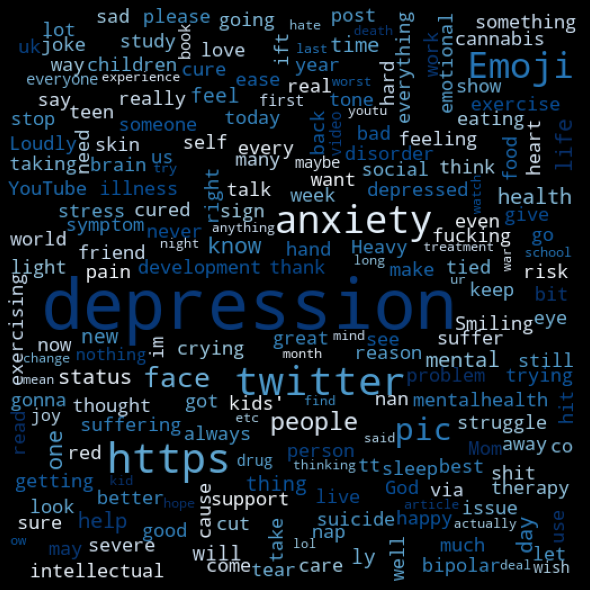

In [ ]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [ ]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)


In [ ]:
vocab_length = len(tokenizer.word_index) + 1

In [ ]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)

print(len(data_d))
print(len(data_r))

2308
3949


In [ ]:
# from sklearn.model_selection import train_test_split

# data= np.concatenate(np.array(data_d),np.array(data_r))
# labels_d = np.array([1] * DEPRES_NROWS)
# labels_r = np.array([0] * RANDOM_NROWS)
# labels=np.concatenate(labels_d,labels_r)
# x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)


In [ ]:
labels_d = np.array([0] * DEPRES_NROWS)
labels_r = np.array(random_tweets_df['Sentiment'])

In [ ]:
#Assigning labels to the depressive tweets and random tweets data


# Splitting the arrays into train (80%), and test data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))


# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]


In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(X_d + X_r, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!wget 'http://nlp.stanford.edu/data/glove.6B.zip'

--2021-06-03 17:59:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-03 17:59:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-03 17:59:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip '/content/glove.6B.zip'

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embeddings_dictionary = dict()
embedding_file = open('/content/glove.6B.300d.txt')

In [ ]:
for line in embedding_file:
  records = line.split()
  word = records[0]
  vector = np.asarray(records[1:], dtype = 'float32')
  embeddings_dictionary[word] = vector

embedding_file.close()

In [ ]:
embedding_matrix = np.zeros((vocab_length, 300))
for word, index in tokenizer.word_index.items():
  embeddings_vector = embeddings_dictionary.get(word)
  if embeddings_vector is not None:
    embedding_matrix[index] = embeddings_vector

In [ ]:
print(len(data_train))
print(len(labels_test))
print(sum(labels_test))

5795
1252
224


In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=None):
    if logs['val_acc']>0.94:
      print("\naccuracy above 94% reached\n")
      self.model.stop_training=True
      

In [ ]:
model = Sequential()
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Bidirectional(LSTM(100, return_sequences = True)))
model.add(Bidirectional(LSTM(100, return_sequences = True)))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 140, 300)          3870000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 140, 200)          320800    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 140, 200)          240800    
_________________________________________________________________
dense_41 (Dense)             (None, 140, 64)           12864     
_________________________________________________________________
dense_42 (Dense)             (None, 140, 1)            65        
Total params: 4,444,529
Trainable params: 574,529
Non-trainable params: 3,870,000
_________________________________________________________________


In [ ]:

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
history = model.fit(data_train, labels_train,batch_size=16, epochs = 10, validation_data= (data_test, labels_test), shuffle=True, callbacks=[CustomCallback()])

Epoch 1/10
363/363 [==============================] - 18s 35ms/step - loss: 0.4968 - acc: 0.8081 - val_loss: 0.3984 - val_acc: 0.8211
Epoch 2/10
363/363 [==============================] - 11s 30ms/step - loss: 0.4228 - acc: 0.8159 - val_loss: 0.3828 - val_acc: 0.8211
Epoch 3/10
363/363 [==============================] - 11s 29ms/step - loss: 0.4097 - acc: 0.8059 - val_loss: 0.3720 - val_acc: 0.8211
Epoch 4/10
363/363 [==============================] - 11s 30ms/step - loss: 0.3987 - acc: 0.8111 - val_loss: 0.3563 - val_acc: 0.8211
Epoch 5/10
363/363 [==============================] - 11s 30ms/step - loss: 0.3823 - acc: 0.8108 - val_loss: 0.3336 - val_acc: 0.8212
Epoch 6/10
363/363 [==============================] - 11s 30ms/step - loss: 0.3455 - acc: 0.8233 - val_loss: 0.3147 - val_acc: 0.8314
Epoch 7/10
363/363 [==============================] - 11s 30ms/step - loss: 0.3347 - acc: 0.8407 - val_loss: 0.2649 - val_acc: 0.8688
Epoch 8/10
363/363 [==============================] - 11s 30ms

In [ ]:
model1 = Sequential()
model1.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model1.add(LSTM(50))
model1.add(Dropout(0.1))
model1.add(Dense(1, activation = 'sigmoid'))
model1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 140, 300)          3870000   
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                70200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 51        
Total params: 3,940,251
Trainable params: 70,251
Non-trainable params: 3,870,000
_________________________________________________________________


In [ ]:
from keras import optimizers
adam = optimizers.Adam(learning_rate=0.05)
model1.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
history1 = model1.fit(data_train, labels_train,batch_size=16, epochs = 10, validation_data= (data_test, labels_test), shuffle=True, callbacks=[CustomCallback()])

Epoch 1/10
363/363 [==============================] - 3s 9ms/step - loss: 0.3615 - acc: 0.8311 - val_loss: 0.3019 - val_acc: 0.8650
Epoch 2/10
363/363 [==============================] - 3s 8ms/step - loss: 0.3453 - acc: 0.8393 - val_loss: 0.3011 - val_acc: 0.8602
Epoch 3/10
363/363 [==============================] - 3s 8ms/step - loss: 0.3436 - acc: 0.8428 - val_loss: 0.2955 - val_acc: 0.8634
Epoch 4/10
363/363 [==============================] - 3s 8ms/step - loss: 0.3394 - acc: 0.8454 - val_loss: 0.3022 - val_acc: 0.8506
Epoch 5/10
363/363 [==============================] - 3s 8ms/step - loss: 0.3386 - acc: 0.8412 - val_loss: 0.2867 - val_acc: 0.8698
Epoch 6/10
363/363 [==============================] - 3s 8ms/step - loss: 0.3312 - acc: 0.8445 - val_loss: 0.2626 - val_acc: 0.8802
Epoch 7/10
363/363 [==============================] - 3s 8ms/step - loss: 0.3214 - acc: 0.8511 - val_loss: 0.2816 - val_acc: 0.8674
Epoch 8/10
363/363 [==============================] - 3s 8ms/step - loss: 0.

In [ ]:
model2 = Sequential()
model2.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model2.add(GRU(100))
model2.add(Dropout(0.1))
model2.add(Dense(1, activation = 'sigmoid'))
model2.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 140, 300)          3870000   
_________________________________________________________________
gru_7 (GRU)                  (None, 100)               120600    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 101       
Total params: 3,990,701
Trainable params: 120,701
Non-trainable params: 3,870,000
_________________________________________________________________


In [ ]:
adam = optimizers.Adam(learning_rate=0.025)
model2.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
history2 = model2.fit(data_train, labels_train,batch_size=16, epochs = 10, validation_data= (data_test, labels_test), shuffle=True)

Epoch 1/10
363/363 [==============================] - 6s 11ms/step - loss: 0.4944 - acc: 0.7905 - val_loss: 0.4152 - val_acc: 0.7939
Epoch 2/10
363/363 [==============================] - 3s 9ms/step - loss: 0.4453 - acc: 0.7910 - val_loss: 0.3479 - val_acc: 0.8259
Epoch 3/10
363/363 [==============================] - 3s 9ms/step - loss: 0.4222 - acc: 0.8014 - val_loss: 0.3108 - val_acc: 0.8514
Epoch 4/10
363/363 [==============================] - 3s 9ms/step - loss: 0.3478 - acc: 0.8372 - val_loss: 0.2880 - val_acc: 0.8690
Epoch 5/10
363/363 [==============================] - 3s 9ms/step - loss: 0.3411 - acc: 0.8463 - val_loss: 0.2535 - val_acc: 0.8842
Epoch 6/10
363/363 [==============================] - 3s 9ms/step - loss: 0.3251 - acc: 0.8539 - val_loss: 0.2447 - val_acc: 0.8890
Epoch 7/10
363/363 [==============================] - 3s 9ms/step - loss: 0.2806 - acc: 0.8755 - val_loss: 0.2236 - val_acc: 0.8858
Epoch 8/10
363/363 [==============================] - 3s 9ms/step - loss: 0

In [ ]:
model1.save('/content/drive/My Drive/lstm.h5')

In [ ]:
model2.save('/content/drive/My Drive/gru.h5')

In [ ]:
pred=model.predict(data_test)
pred.flatten()
res=[]
for i in pred:
  res.append(round(i[0][0]))
print(res)

[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(labels_test, res, digits=5))

              precision    recall  f1-score   support

           0    0.97162   0.96595   0.96878      1028
           1    0.84783   0.87054   0.85903       224

    accuracy                        0.94888      1252
   macro avg    0.90973   0.91824   0.91391      1252
weighted avg    0.94948   0.94888   0.94914      1252



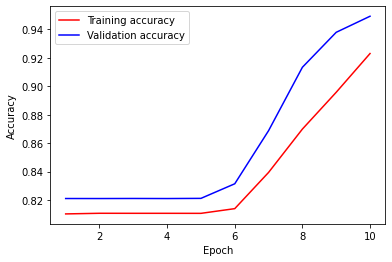

In [ ]:
training_loss = history.history['acc']
validation_loss = history.history['val_acc']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, color = 'red')
plt.plot(epoch_count, validation_loss, color = 'blue')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Text(33.0, 0.5, 'Actual')

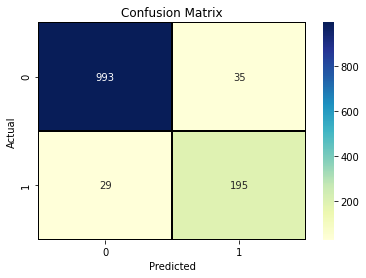

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(labels_test,res)
sns.heatmap(cm, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
model.save('/content/drive/My Drive/bilstm.h5')

In [ ]:
pred1=model1.predict(data_test)
print(pred1)
res1=[]
for i in pred1:
  res1.append(round(i[0]))
print(res1)

[[3.0525271e-03]
 [3.4420355e-03]
 [1.3361320e-01]
 ...
 [4.9615268e-05]
 [1.3515810e-03]
 [8.0468677e-02]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(labels_test, res1, digits=5))

              precision    recall  f1-score   support

           0    0.88830   0.98249   0.93303      1028
           1    0.84348   0.43304   0.57227       224

    accuracy                        0.88419      1252
   macro avg    0.86589   0.70776   0.75265      1252
weighted avg    0.88028   0.88419   0.86848      1252



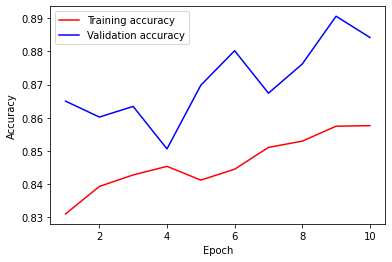

In [ ]:
training_loss = history1.history['acc']
validation_loss = history1.history['val_acc']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, color = 'red')
plt.plot(epoch_count, validation_loss, color = 'blue')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Text(33.0, 0.5, 'Actual')

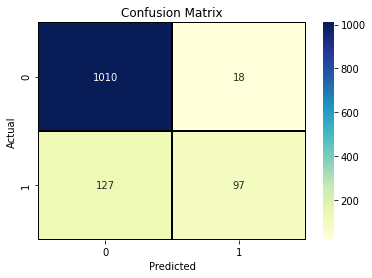

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(labels_test,res1)
sns.heatmap(cm, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
pred2=model2.predict(data_test)
res2=[]
for i in pred2:
  res2.append(round(i[0]))
print(res2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(labels_test, res2, digits=5))

              precision    recall  f1-score   support

           0    0.89947   0.99222   0.94357      1028
           1    0.93220   0.49107   0.64327       224

    accuracy                        0.90256      1252
   macro avg    0.91584   0.74164   0.79342      1252
weighted avg    0.90533   0.90256   0.88984      1252



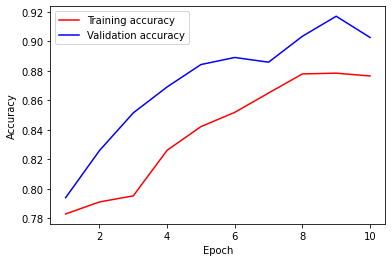

In [ ]:
training_loss = history2.history['acc']
validation_loss = history2.history['val_acc']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, color = 'red')
plt.plot(epoch_count, validation_loss, color = 'blue')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Text(33.0, 0.5, 'Actual')

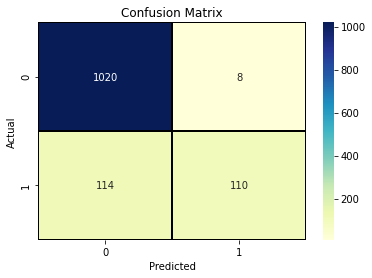

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(labels_test,res2)
sns.heatmap(cm, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

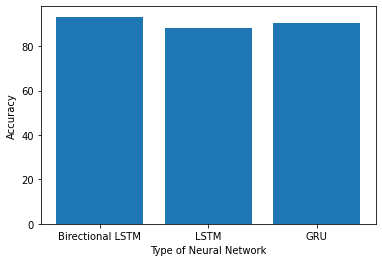

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

alg = ['Birectional LSTM', 'LSTM','GRU']
accuracy = [93.291,88.419,90.256]
plt.bar(alg,accuracy)
plt.xlabel("Type of Neural Network")
plt.ylabel("Accuracy")
plt.show()

<Figure size 432x288 with 0 Axes>

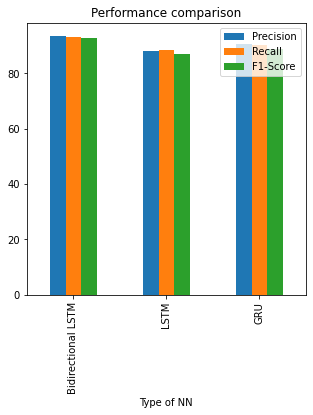

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

alg = ['Birectional LSTM', 'LSTM','GRU']
dfplot=pd.DataFrame([['Bidirectional LSTM',93.586,93.291,92.775,],['LSTM',88.028,88.419,86.848],['GRU',90.533,90.256,88.984]], columns=['Type of NN','Precision','Recall','F1-Score']) 

dfplot.plot(x='Type of NN',
        kind='bar',
        stacked=False,
        title='Performance comparison',figsize=(5,5))


In [ ]:
from keras.models import load_model
new_model=load_model('/content/drive/My Drive/bilstm.h5')
new_model.summary()

OSError: ignored

In [ ]:
preds=new_model.predict(data_test)
preds.flatten()
res1=[]
for i in preds:
  res1.append(round(i[0][0]))
print(res1)

NameError: ignored

In [ ]:
print(classification_report(labels_test, res1, digits=5))

              precision    recall  f1-score   support

           0    0.90081   0.98401   0.94058       563
           1    0.98587   0.91147   0.94721       689

    accuracy                        0.94409      1252
   macro avg    0.94334   0.94774   0.94389      1252
weighted avg    0.94762   0.94409   0.94423      1252



Text(33.0, 0.5, 'Predicted')

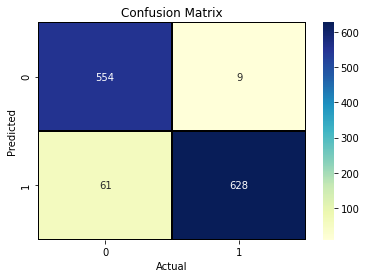

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(labels_test,res1)
sns.heatmap(cm, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix")
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")